In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [2]:
# High number of epochs, change for faster results
import numpy as np

# only a batch size of 1 works with hinge loss right now, with bce loss a larger batch size works, but in general a smaller batch size leads to better convergence, but still could theoretically introduce more noise
BATCH_SIZE = 1
EPOCHS = 100
SEED = 2


In [3]:
# this sample data is found in folder data
def read_raw_data(filename):
    raw_data = []
    with open(filename) as f:
        for line in f:
            raw_data.append(line.strip())
    return raw_data
raw_train_data = read_raw_data('data/mul_class_86_train_data.txt')
raw_dev_data = read_raw_data('data/mul_class_86_dev_data_1.txt')

In [4]:
from nltk import word_tokenize

vocab = []
for sen in raw_train_data:
    for word in word_tokenize(sen):
        vocab.append(word)

vocab = list(set(vocab))

In [5]:
vocab

['grain',
 'eats',
 'meows',
 'squeaks',
 'runs',
 'mouse',
 'fox',
 'in',
 'whale',
 'bone',
 'clucks',
 'barks',
 'fish',
 'cheese',
 'chicken',
 'flees',
 'chases',
 'bites',
 'swims',
 'after',
 'land',
 'cat',
 'on',
 'krill',
 'at',
 'seal',
 'water',
 'dog']

In [6]:
def create_training_data(raw_training):
    training_data = []
    training_labels = []
    masked_tokens = []
    for sen in raw_training:
        masked_word = word_tokenize(sen)[-1]
        masked_tokens.append(masked_word)

        training_data.append(' '.join(word_tokenize(sen)[:-1]))

        label = [0]*32
        label[vocab.index(masked_word)] = 1
        training_labels.append(label)

    return training_labels, training_data, masked_tokens
training_labels, training_data, training_tokens = create_training_data(raw_train_data)
dev_labels, dev_data, dev_tokens = create_training_data(raw_dev_data)

In [7]:
from discopy import Functor, Ty, Word, Id, Cup, Diagram

s, n = Ty('s'), Ty('n')
tv = n.r @ s @ n.l
iv = n.r @ s
p = s.r @ n.r.r @ n.r @ s @ n.l

# grammars
grammars = [Cup(n, n.r) @ Id(s),
            Cup(n, n.r) @ Id(s) @ Cup(n.l, n),
            (Id(n) @ Id(n.r) @ Cup(s, s.r) @ Id(n.r.r) @ Id(n.r) >> Id(n) @ Cup(n.r, n.r.r) @ Id(n.r) >> Cup(n, n.r)) @ Id(s) @ Cup(n.l, n)]

class WordBox(Word):
    """ Word with Ty((name, cod)) as domain. """
    def __init__(self, name, cod):
        super().__init__(name, cod, dom=Ty())

def parse(dataset):
    diagram_list = []
    for tup in dataset:
        sen = tup
        tokenized_sen = word_tokenize(sen)
        lenght = len(tokenized_sen)
        if lenght == 2:
            subj_box = WordBox(tokenized_sen[0], n)
            verb_box = WordBox(tokenized_sen[1], iv)
            diagram = subj_box @ verb_box >> grammars[0]
        elif lenght == 3:
            subj_box = WordBox(tokenized_sen[0], n)
            verb_box = WordBox(tokenized_sen[1], tv)
            dobj_box = WordBox(tokenized_sen[2], n)
            diagram = subj_box @ verb_box @ dobj_box >> grammars[1]
        else:
            subj_box = WordBox(tokenized_sen[0], n)
            verb_box = WordBox(tokenized_sen[1], iv)
            prep_box = WordBox(tokenized_sen[2], p)
            idobj_box = WordBox(tokenized_sen[3], n)
            diagram = subj_box @ verb_box @ prep_box @ idobj_box >> grammars[2]
        diagram_list.append(diagram)
    return diagram_list

In [8]:
uncuped_train_diagrams = parse(training_data)
uncuped_dev_diagrams = parse(dev_data)

In [9]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in uncuped_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in uncuped_dev_diagrams]

In [10]:
# another import from sklearn, may contain large files
from sklearn.metrics import hinge_loss as hinge_sk
from torch.nn import CrossEntropyLoss
import torch
# different loss functions, hinge loss outperforms binary cross entropy loss
def hinge_loss(y_hat, y):
    return hinge_sk(y[0], y_hat.flatten())

def bce_loss(y_hat, y):
    return -np.sum(y * np.log(y_hat)) / len(y)

loss = CrossEntropyLoss()

def CEL(y_hat, y):
    flattened_y_hat = y_hat.flatten()
    return float(loss(torch.tensor(flattened_y_hat), torch.tensor(y[0])))

In [11]:
def acc(y_hat, y):
    a=y_hat.flatten()
    #b=y_hat
    max_index = np.argmax(a)
    new_arr = np.zeros(a.shape)
    new_arr[max_index] = 1
    if np.array_equal(new_arr, y[0]):
        return 1
    else:
        return 0

In [12]:
from lambeq import AtomicType
from my_circuit_3 import IQPAnsatz

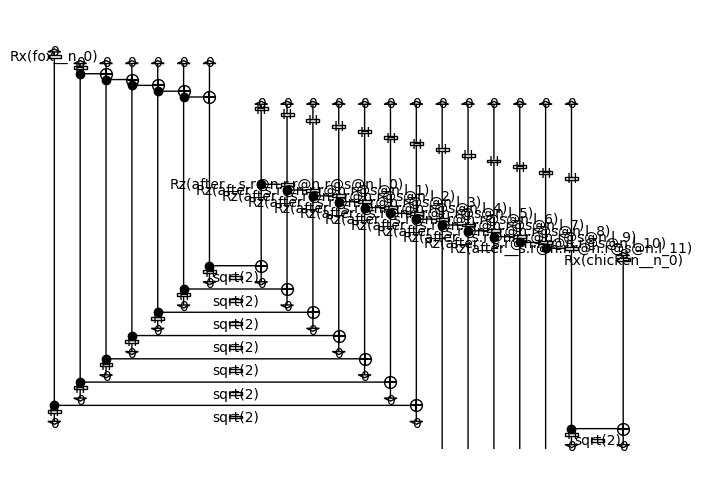

'for index, diagram in enumerate(uncuped_train_diagrams):\n    ansatz = IQPAnsatz(masked_token = training_tokens[index],ob_map={N: 1, S: 5, P:1}, n_layers=4, n_single_qubit_params=8)\n    train_circuits.append(ansatz(diagram))\nfor index, diagram in enumerate(uncuped_dev_diagrams):\n    ansatz = IQPAnsatz(masked_token = dev_tokens[index],ob_map={N: 1, S: 5, P:1}, n_layers=4, n_single_qubit_params=8)\n    dev_circuits.append(ansatz(diagram))'

In [13]:

N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE
train_circuits = []
dev_circuits = []
ansatz = IQPAnsatz(masked_token = 'runs',ob_map={N: 1, S: 5, P:1}, n_layers=1, n_single_qubit_params=1)
circuit = ansatz(train_diagrams[0])
circuit.draw()
'''for index, diagram in enumerate(uncuped_train_diagrams):
    ansatz = IQPAnsatz(masked_token = training_tokens[index],ob_map={N: 1, S: 5, P:1}, n_layers=4, n_single_qubit_params=8)
    train_circuits.append(ansatz(diagram))
for index, diagram in enumerate(uncuped_dev_diagrams):
    ansatz = IQPAnsatz(masked_token = dev_tokens[index],ob_map={N: 1, S: 5, P:1}, n_layers=4, n_single_qubit_params=8)
    dev_circuits.append(ansatz(diagram))'''

In [18]:
from lambeq import NumpyModel

all_circuits = train_circuits + dev_circuits
model = NumpyModel.from_diagrams(train_circuits)

In [19]:
from lambeq import QuantumTrainer, SPSAOptimizer

# here you can play around with hyperparameters
trainer = QuantumTrainer(
    model,
    loss_function=CEL,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [20]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            training_labels,
            batch_size=1,
            shuffle=True)
val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False, batch_size=1)

In [21]:
trainer.fit(train_dataset, val_dataset, logging_step=1)

Epoch 1:    train/loss: 3.4705   valid/loss: 3.4878   train/acc: 0.0465   valid/acc: 0.0000
Epoch 2:    train/loss: 3.4700   valid/loss: 3.4860   train/acc: 0.0814   valid/acc: 0.0000
Epoch 3:    train/loss: 3.4629   valid/loss: 3.4836   train/acc: 0.0930   valid/acc: 0.0000
Epoch 4:    train/loss: 3.4596   valid/loss: 3.4859   train/acc: 0.1047   valid/acc: 0.0000
Epoch 5:    train/loss: 3.4567   valid/loss: 3.4842   train/acc: 0.0930   valid/acc: 0.0000
Epoch 6:    train/loss: 3.4562   valid/loss: 3.4833   train/acc: 0.0930   valid/acc: 0.0000
Epoch 7:    train/loss: 3.4525   valid/loss: 3.4796   train/acc: 0.1163   valid/acc: 0.0000
Epoch 8:    train/loss: 3.4518   valid/loss: 3.4770   train/acc: 0.0930   valid/acc: 0.0435
Epoch 9:    train/loss: 3.4490   valid/loss: 3.4771   train/acc: 0.1512   valid/acc: 0.0000
Epoch 10:   train/loss: 3.4493   valid/loss: 3.4775   train/acc: 0.1395   valid/acc: 0.0000
Epoch 11:   train/loss: 3.4449   valid/loss: 3.4814   train/acc: 0.1395   valid/

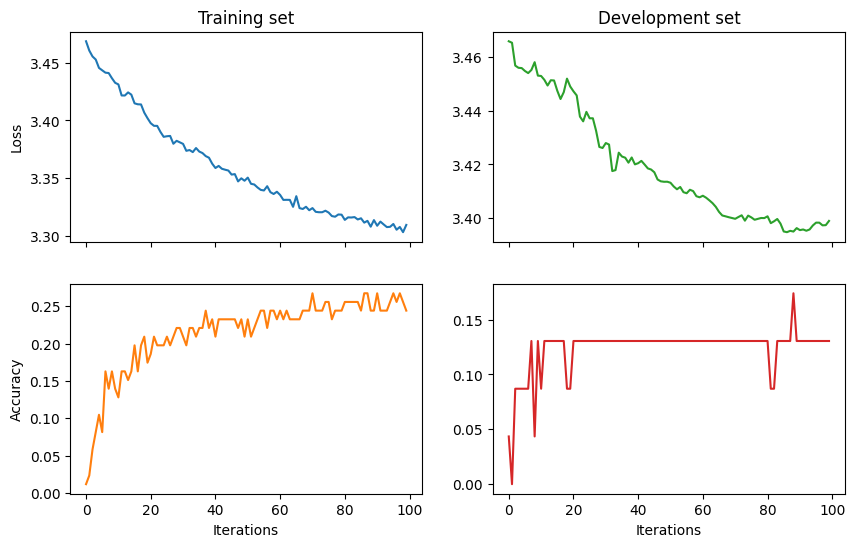

In [42]:
# plotting the results
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))
